## Before using this notebook the initW and all other synaptic parameters are hard coded into this notebook. Make sure to update the parameters before using notebook. Currently all parameters but initW are updated.

E rev for GABA A synapse is from Two Dynamically Distinct Inhibitory Networks in Layer 4 of the Neocortex

In [39]:
import neuron
from neuron import h
from neuron.units import ms, mV
import numpy as np
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import json
import os
import ipywidgets as widgets
from ipywidgets import interactive_output,HBox,VBox,Label,Layout
from IPython.display import display
from IPython.display import clear_output
%matplotlib inline

h.load_file('stdrun.hoc')
neuron.load_mechanisms('../Network-Parameters/components/mechanisms')
h.load_file('../Network-Parameters/components/templates/templates.hoc') # reads in template

h.dt = 0.025 # time step (resolution) of the simulation in ms
h.steps_per_ms = 1 / h.dt
h.celsius = 36.0

Connection = 'FSI2FSI'

Mechanisms already loaded from path: ../Network-Parameters/components/mechanisms.  Aborting.


### Set parameters for different connection types

#### Basic settings

In [40]:
default_settings = {
    'post_cell': 'CP_Cell',
    'sec_id': 1,
    'sec_x': 0.5,
    'syn_type': 'AMPA_NMDA_STP',
    'vclamp': True,
    'vclamp_amp': -60.,
    'rise_interval': (0.2, 0.8),
    'tstart': 500.,
    'tdur': 1100.,
    'threshold': 0., # netcon
    'delay': 1.6, # netcon
    'weight': 1., # netcon
}
syn_param_exc = {
    'initW': 1.0,
    'tau_r_AMPA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_AMPA': 1.7, # (ms) IMPORTANT: tau_r < tau_d
    'Use': 1., # (1) Utilization of synaptic efficacy
    'Dep': 100., # (ms) Relaxation time constant from depression
    'Fac': 10., # (ms) Relaxation time constant from facilitation
}
syn_param_inh = {
    'initW': 1.0,
    'tau_r_GABAA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_GABAA': 8., # (ms) IMPORTANT: tau_r < tau_d
    'Use': 1., # (1) Utilization of synaptic efficacy
    'Dep': 100., # (ms) Relaxation time constant from depression
    'Fac': 10., # (ms) Relaxation time constant from facilitation
}
syn_param_dict = {'AMPA_NMDA_STP': syn_param_exc, 'GABA_A_STP': syn_param_inh}

#### Settings for individual conection types

In [41]:
conn_type_settings = {
    'PN2PN': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_x': 0.4,
        },
        'spec_syn_param': {
            'initW': 3.2,
            'tau_d_AMPA': 5.2,
            'Use': 0.37,
            'Dep': 31.7,
            'Fac': 519.,
        },
    },
    'PN2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'rise_interval': (0.1, 0.9),
        },
        'spec_syn_param': {
            'initW': 3.1,
            'tau_r_AMPA': 0.4,
            'tau_d_AMPA': 2.9,
            'Use': 0.035,
            'Dep': 500.,
            'Fac': 0.
        },
    },
    'PN2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
            'vclamp': False,
            'rise_interval': (0.1, 0.9),
        },
        'spec_syn_param': {
            'initW': 1.,
            'tau_r_AMPA': 0.4,
            'tau_d_AMPA': 3.9,
            'Use': 0.05,
            'Dep': 0.,
            'Fac': 200.
        },
    },
    'FSI2PN': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_id': 0,
            'syn_type': 'GABA_A_STP',
            'vclamp': False,
            'vclamp_amp': -60.,
        },
        'spec_syn_param': {
            'initW': 3.8,
            'tau_d_GABAA': 7.,
            'e_GABAA': -90.,
            'Use': 0.3,
            'Dep': 400.,
            'Fac': 0.
        },
    },
    'LTS2PN': {
        'spec_settings': {
            'post_cell': 'CP_Cell',
            'sec_id': 2,
            'sec_x': 0.8,
            'syn_type': 'GABA_A_STP',
            'vclamp': False,
            'vclamp_amp': -60.,
        },
        'spec_syn_param': {
            'initW': 1.,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 30.,
            'e_GABAA': -75.,
            'Use': 0.3,
            'Dep': 25.,
            'Fac': 200.
        },
    },
    'FSI2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'sec_id': 0,
            'syn_type': 'GABA_A_STP',
            'vclamp_amp': -50.,
            'rise_interval': (0.1, 0.9),
        },
        'spec_syn_param': {
            'initW': 10.,
            'tau_d_GABAA': 5.,
            'Use': 0.3,
            'Dep': 400.,
            'Fac': 0.
        },
    },
    'FSI2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
            'sec_id': 0,
            'syn_type': 'GABA_A_STP',
            'vclamp_amp': -60.,
            'rise_interval': (0.1, 0.9),
        },
        'spec_syn_param': {
            'initW': 15.0,
            'tau_d_GABAA': 5.,
            'Use': 0.3,
            'Dep': 400.,
            'Fac': 0.
        },
    },
    'LTS2FSI': {
        'spec_settings': {
            'post_cell': 'FSI_Cell',
            'sec_id': 0,
            'syn_type': 'GABA_A_STP',
            'vclamp_amp': -50.,
            'rise_interval': (0.1, 0.9),
        },
        'spec_syn_param': {
            'initW': 0.8,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 20.,
            'Use': 0.3,
            'Dep': 25.,
            'Fac': 100.
        },
    },
    'LTS2LTS': {
        'spec_settings': {
            'post_cell': 'LTS_Cell',
            'sec_id': 0,
            'syn_type': 'GABA_A_STP',
            'vclamp_amp': -60.,
            'rise_interval': (0.1, 0.9),
        },
        'spec_syn_param': {
            'initW': 2.5,
            'tau_r_GABAA': 0.9,
            'tau_d_GABAA': 20.,
            'Use': 0.3,
            'Dep': 25.,
            'Fac': 200.
        },
    },
}

In [42]:
def update_spec_syn_param(conn_type_settings, json_folder_path):
    "updated spec syn with values from json files used in simulation"
    for conn_type, settings in conn_type_settings.items():
        json_file_path = os.path.join(json_folder_path, f"{conn_type}.json")
        if os.path.exists(json_file_path):
            with open(json_file_path, 'r') as json_file:
                json_data = json.load(json_file)
                settings['spec_syn_param'].update(json_data)
        else:
            print(f"JSON file for {conn_type} not found.")
    return conn_type_settings

conn_type_settings = update_spec_syn_param(conn_type_settings, "../Network-Parameters/components/synaptic_models/synapses_STP")
print(conn_type_settings)


{'PN2PN': {'spec_settings': {'post_cell': 'CP_Cell', 'sec_x': 0.4}, 'spec_syn_param': {'initW': 3.2, 'tau_d_AMPA': 5.2, 'Use': 0.37, 'Dep': 31.7, 'Fac': 519.0, 'level_of_detail': 'AMPA_NMDA_STP', 'tau_r_AMPA': 0.2, 'e': 0}}, 'PN2FSI': {'spec_settings': {'post_cell': 'FSI_Cell', 'rise_interval': (0.1, 0.9)}, 'spec_syn_param': {'initW': 3.1, 'tau_r_AMPA': 0.4, 'tau_d_AMPA': 2.9, 'Use': 0.035, 'Dep': 500.0, 'Fac': 0.0, 'level_of_detail': 'AMPA_NMDA_STP', 'e': 0}}, 'PN2LTS': {'spec_settings': {'post_cell': 'LTS_Cell', 'vclamp': False, 'rise_interval': (0.1, 0.9)}, 'spec_syn_param': {'initW': 1, 'tau_r_AMPA': 0.4, 'tau_d_AMPA': 3.9, 'Use': 0.05, 'Dep': 0.0, 'Fac': 200.0, 'level_of_detail': 'AMPA_NMDA_STP', 'e': 0}}, 'FSI2PN': {'spec_settings': {'post_cell': 'CP_Cell', 'sec_id': 0, 'syn_type': 'GABA_A_STP', 'vclamp': False, 'vclamp_amp': -60.0}, 'spec_syn_param': {'initW': 3.8, 'tau_d_GABAA': 7.0, 'e_GABAA': -75.0, 'Use': 0.3, 'Dep': 400.0, 'Fac': 0.0, 'level_of_detail': 'GABA_AB_STP', 'tau_

In [43]:
conn_type_setting = conn_type_settings[Connection]
settings = default_settings.copy()
settings.update(conn_type_setting['spec_settings'])
syn_param = syn_param_dict[settings['syn_type']].copy()
syn_param.update(conn_type_setting['spec_syn_param'])

### Set up model for simulation

In [44]:
tstart = settings['tstart']
tdur = settings['tdur']
h.tstop = tstop = tstart + tdur # how long to run the simulation in ms

cell = getattr(h, settings['post_cell'])()
syn = getattr(h, settings['syn_type'])(list(cell.all)[settings['sec_id']](settings['sec_x']))
nstim = h.NetStim()
nstim.start = tstart
nstim.noise = 0
nc = h.NetCon(nstim, syn, settings['threshold'], settings['delay'], settings['weight'])
vcl = h.VClamp(cell.soma[0](0.5))
vcldur = [[0, 0, 0],[tstart, tstop, 1e9]]
vcl_on = True
for i in range(3):
    vcl.amp[i] = settings['vclamp_amp']

def switch_vclamp(on=True):
    global vcl_on
    vcl_on = on
    on = int(on)
    for i in range(3):
        vcl.dur[i] = vcldur[on][i]

switch_vclamp(settings['vclamp'])

t = h.Vector() # Vectors are used to record data in the simulation
tspk = h.Vector() # synapse event times
soma_v = h.Vector()
ivcl = h.Vector()
isyn = h.Vector()
Use_rec = h.Vector()
Pr = h.Vector()
# record data
t.record(h._ref_t)
nc.record(tspk)
soma_v.record(cell.soma[0](0.5)._ref_v)
ivcl.record(vcl._ref_i)
isyn.record(syn._ref_i)
Pr.record(syn._ref_record_Pr)
Use_rec.record(syn._ref_record_use)

Vector[35]

### Single synaptic event and evaluate properties

#### Functions for estimating synaptic properties

In [45]:
def find_first(x):
    x = np.asarray(x)
    idx = np.nonzero(x)[0]
    if idx.size:
        return idx[0]
    else:
        return None

def get_syn_prop(isyn, tspk, rise_interval=(0.2, 0.8), dt=h.dt):
    isyn = np.asarray(isyn)
    tspk = np.asarray(tspk)
    if tspk.size:
        tspk = tspk[0]
    ispk = int(np.floor(tspk / dt))
    baseline = isyn[ispk]
    isyn = isyn[ispk:] - baseline
    sign = np.sign(isyn[np.argmax(np.abs(isyn))])
    isyn *= sign
    # peak amplitude
    ipk, _ = find_peaks(isyn)
    ipk = ipk[0]
    peak = isyn[ipk]
    # latency
    istart = find_first(np.diff(isyn[:ipk + 1]) > 0)
    latency = dt * (istart + 1)
    # rise time
    rt1 = find_first(isyn[istart:ipk + 1] > rise_interval[0] * peak)
    rt2 = find_first(isyn[istart:ipk + 1] > rise_interval[1] * peak)
    rise_time = (rt2 - rt1) * dt
    # decay time
    iend = find_first(np.diff(isyn[ipk:]) > 0)
    iend = isyn.size - 1 if iend is None else iend + ipk
    decay_len = iend - ipk + 1
    popt, _ = curve_fit(lambda t, a, tau: a * np.exp(-t / tau), dt * np.arange(decay_len),
                        isyn[ipk:iend + 1], p0=(peak, dt * decay_len / 2))
    decay_time = popt[1]
    # Generate fitted curve
    a, tau = popt
    fitted_curve = a * np.exp(-t / tau)

    # Plot the original data and the fitted curve
    plt.figure(figsize=(10, 6))
    plt.plot(isyn, 'bo', label='Original data')
    plt.plot(fitted_curve, 'r-', label='Fitted curve')
    plt.xlabel('Time (s)')
    plt.ylabel('isyn')
    plt.title('Curve Fit')
    plt.legend()
    plt.show()
    # half-width
    hw1 = find_first(isyn[istart:ipk + 1] > 0.5 * peak)
    hw2 = find_first(isyn[ipk:] < 0.5 * peak)
    hw2 = isyn.size if hw2 is None else hw2 + ipk
    half_width = dt * (hw2 - hw1)
    output = {'baseline': baseline, 'sign': sign, 'latency': latency,
          'amp': peak, 'rise_time': rise_time, 'decay_time': decay_time, 'half_width': half_width}
    return output

def paired_pulse_ratio(isyn, tspk, dt=h.dt):
    isyn = np.asarray(isyn)
    tspk = np.asarray(tspk)
    if tspk.size < 2:
        raise ValueError("Need at least two spikes.")
    syn_prop = get_syn_prop(isyn, tspk, dt=dt)
    isyn = (isyn - syn_prop['baseline']) * syn_prop['sign']
    ispk2 = int(np.floor(tspk[1] / dt))
    ipk, _ = find_peaks(isyn[ispk2:])
    ipk2 = ipk[0] + ispk2
    peak2 = isyn[ipk2]
    return peak2 / syn_prop['amp']

In [46]:
print(syn_param)
# change synaptic parameters for tuning
'''
syn_param.update({
    'initW': 1.3,
    'tau_r_GABAA': 0.2, # (ms) Dual-exponential conductance profile
    'tau_d_GABAA': 5.0, # (ms) IMPORTANT: tau_r < tau_d
#     'e_GABAA': -75.,
})
print(syn_param)
# '''
#switch_vclamp(False)
switch_vclamp(True)

nstim.interval = tdur
nstim.number = 1
for key, value in syn_param.items():
    if key == 'level_of_detail': # lazy way to get remove this
        pass
    else:
        setattr(syn, key, value)

h.run()

{'initW': 10.0, 'tau_r_GABAA': 0.7, 'tau_d_GABAA': 5.2, 'Use': 0.3, 'Dep': 400.0, 'Fac': 0.0, 'level_of_detail': 'GABA_AB_STP', 'e_GABAA': -75.0}


0.0

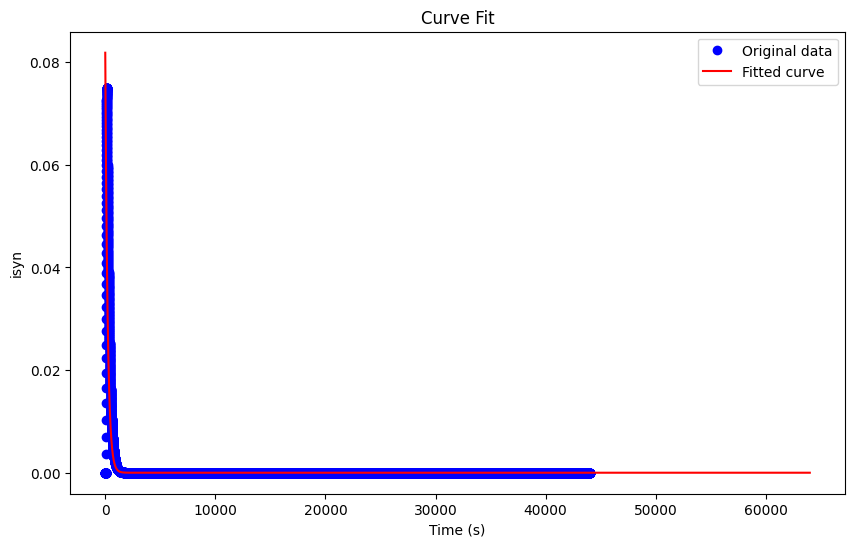

{
  "Cell Pair": "FSI2FSI",
  "baseline": -0.06914366016025042,
  "sign": 1.0,
  "latency": 1.6500000000000001,
  "amp": 0.07500297676373435,
  "rise_time": 0.8500000000000001,
  "decay_time": 5.461400546081542,
  "half_width": 7.275
}


In [47]:
# synaptic current
if vcl_on == False:
    syn_prop = get_syn_prop(isyn if vcl_on else soma_v, tspk, rise_interval=settings['rise_interval'])
    new_syn_prop = {'Cell Pair': Connection}
    new_syn_prop.update(syn_prop)
    print(json.dumps(new_syn_prop, indent=2))
if vcl_on: # clamp current
    syn_prop = get_syn_prop(ivcl, tspk, rise_interval=settings['rise_interval'])
    new_syn_prop = {'Cell Pair': Connection}
    new_syn_prop.update(syn_prop)
    print(json.dumps(new_syn_prop, indent=2))


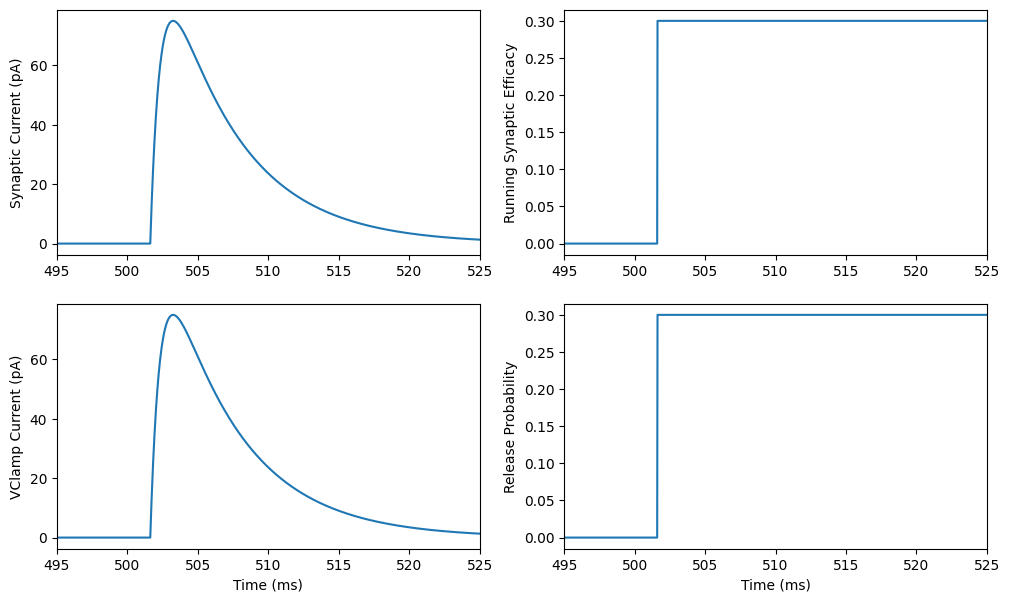

In [48]:
def plot_model(xlim=[]):
    fig, axs = plt.subplots(2, 2, figsize=(12, 7))
    axs = axs.ravel()
    axs[0].plot(t, 1000 * isyn)
    axs[0].set_ylabel('Synaptic Current (pA)')
    ispk = int(np.round(tspk[0] / h.dt))
    if vcl_on:
        baseline = ivcl[ispk]
        ivcl_plt = np.array(ivcl) - baseline
        ivcl_plt[:ispk] = 0
        axs[2].plot(t, 1000 * ivcl_plt)
        axs[2].set_ylabel('VClamp Current (pA)')
    else:
        soma_v_plt = np.array(soma_v)
        soma_v_plt[:ispk] = soma_v_plt[ispk]
        axs[2].plot(t, soma_v_plt)
        axs[2].set_ylabel('Soma Voltage (mV)')
    axs[1].plot(t, Use_rec)
    axs[1].set_ylabel('Running Synaptic Efficacy')
    axs[3].plot(t, Pr)
    axs[3].set_ylabel('Release Probability')
    for i, ax in enumerate(axs):
        ax.set_xlim(*xlim)
        if i > 1:
            ax.set_xlabel('Time (ms)')
    plt.show()

plot_model([tstart - 5, tstart + 25])

### Short term plasticity

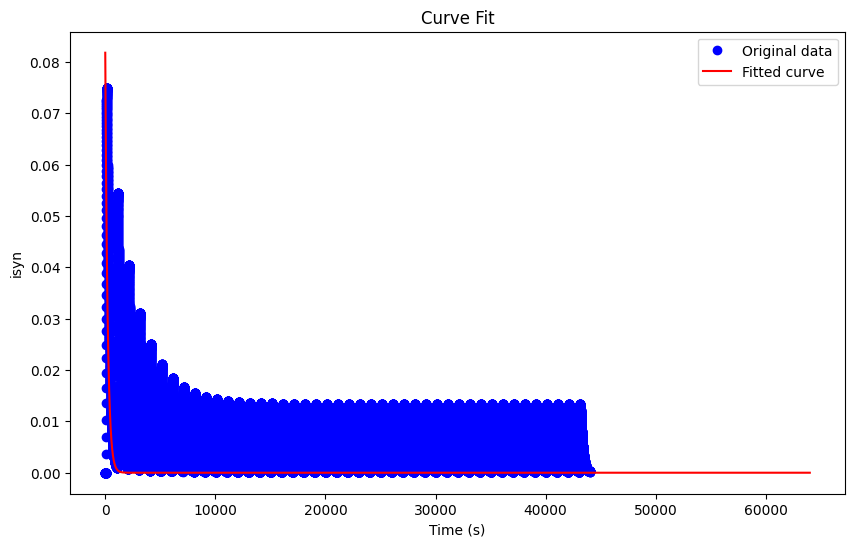

Paired Pulse Ratio using PSC: 0.728


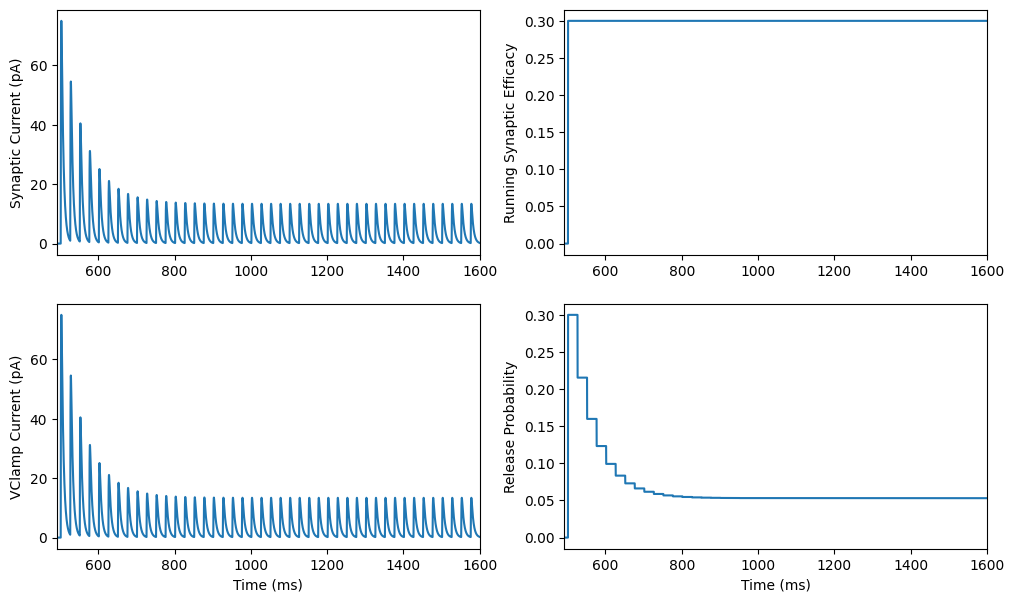

In [49]:
def simulate_model(weight, input_frequency, Use, tau_f, tau_d):
    nstim.interval = 1000 / input_frequency
    nstim.number = np.ceil(tdur / 1000 * input_frequency + 1)
    syn.initW = weight #synaptic weight for our synapse
    syn.Fac = tau_f
    syn.Dep = tau_d
    syn.Use = Use
    
    h.finitialize(cell.Vinit * mV)
    h.continuerun(tstop * ms)

w_run = widgets.Button(description='Run', icon='history', button_style='primary')
w_vclamp = widgets.ToggleButton(value=settings['vclamp'], description='Voltage Clamp', icon='check', button_style='primary')
w_weight = widgets.FloatSlider(value=syn_param['initW'], min=0., max=100., step=1e-3, description='Syn Weight')
w_input_freq = widgets.FloatSlider(value=40, min=1., max=100., step=0.1, description='Input Freq')
w_Use = widgets.FloatSlider(value=syn_param['Use'], min=0.,max=1., step=1e-3, description='Init Efficacy')
w_tau_f = widgets.FloatSlider(value=syn_param['Fac'], min=0, max=1000, step=1e-3, description='tau fac')
w_tau_d = widgets.FloatSlider(value=syn_param['Dep'], min=0, max=1000, step=1e-3, description='tau dep')

def update_ui(*arges):
    clear_output()
    display(ui)
    switch_vclamp(w_vclamp.value)
    simulate_model(w_weight.value, w_input_freq.value, w_Use.value, w_tau_f.value, w_tau_d.value)
    ppr = paired_pulse_ratio(isyn if vcl_on else soma_v, tspk)
    print('Paired Pulse Ratio using ' + ('PSC' if vcl_on else 'PSP') + f': {ppr:.3f}')
    plot_model([tstart - nstim.interval / 3, tstop])
    
w_run.on_click(update_ui) 

ui = VBox([HBox([w_run, w_vclamp]), w_weight, HBox([w_input_freq, w_Use]), HBox([w_tau_d, w_tau_f])])
update_ui()

### Fit PPR

In [50]:
def PPR(freq, Use, tau_d, tau_f):
    t = 1000. / freq # Hz to ms
    rd = np.exp(-t / tau_d)
    rf = np.exp(-t / tau_f)
    ppr = (1. + rf * (1. - Use)) * (1. - rd * Use)
    return ppr

def Fit_PPR(freq, ppr, weight=(1., 1., 1.), Use=None):

    sigma = 1. / np.array(weight)
    if Use is not None:
#         bounds = (0., np.inf)
        bounds = (-np.inf, np.log(1000.))
        popt, _ = curve_fit(lambda f, *args: np.log(PPR(f, Use, *np.exp(args))), freq, np.log(ppr),
                    p0=np.log((50., 50.)), bounds=bounds, sigma=sigma, maxfev=10000)
    else:
#         bounds = ((0., 0., 0.), (1., np.inf, np.inf))
        bounds = (-np.inf, (0., np.log(1000.), np.log(1000.)))
        popt, _ = curve_fit(lambda f, *args: np.log(PPR(f, *np.exp(args))), freq, np.log(ppr),
                            p0=np.log((0.5, 50., 50.)), bounds=bounds, sigma=sigma, maxfev=10000)
    popt = np.exp(popt)
    return popt

In [51]:
# ppr_data = np.array([(10, 2.0), (25, 2.5), (40, 2.3)]).T
# popt = Fit_PPR(ppr_data[0], ppr_data[1], Use=0.13) # , weight=(1., .1, 1.)
# np.set_printoptions(formatter={'float': '{: 0.4g}'.format})
# print(np.array(popt))

### Export parameters to json files

In [52]:
# folder = 'synaptic_models'

# for conn, setting in conn_type_settings.items():
#     settings = default_settings.copy()
#     settings.update(setting['spec_settings'])
#     dynamics_params = {'level_of_detail': settings['syn_type']}
#     dynamics_params.update(setting['spec_syn_param'])
#     with open(os.path.join(folder, conn + '.json'), 'w') as f:
#         json.dump(dynamics_params, f, indent=4)

### Initial spike equivalent synaptic weight

In [53]:
for conn, setting in conn_type_settings.items():
    W = setting['spec_syn_param']['initW'] * setting['spec_syn_param']['Use']
    print(f'{conn:s}: {W:.3g}')

PN2PN: 1.18
PN2FSI: 0.109
PN2LTS: 0.05
FSI2PN: 1.14
LTS2PN: 0.3
FSI2FSI: 3
FSI2LTS: 4.5
LTS2FSI: 0.24
LTS2LTS: 0.75


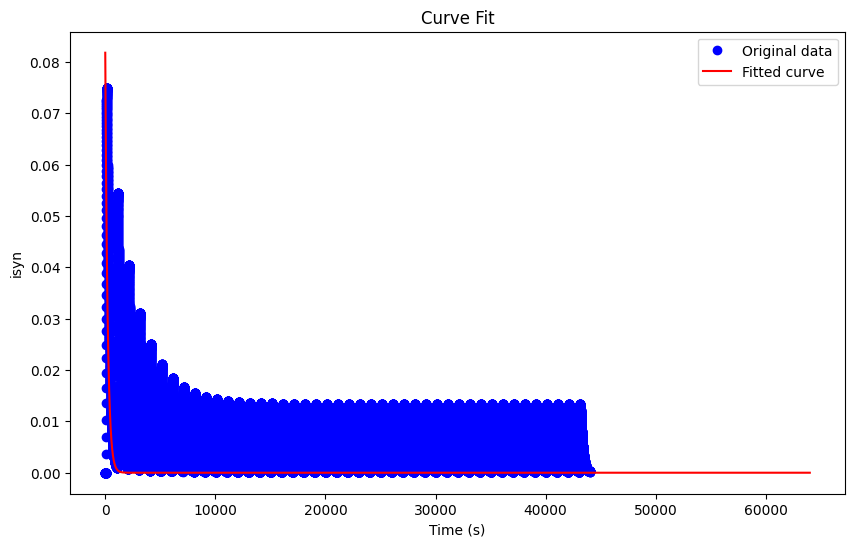

In [54]:
ppr = paired_pulse_ratio(isyn if vcl_on else soma_v, tspk)
new_syn_prop['PPR'] = ppr

In [55]:
new_syn_prop

{'Cell Pair': 'FSI2FSI',
 'baseline': -0.06914366016025042,
 'sign': 1.0,
 'latency': 1.6500000000000001,
 'amp': 0.07500297676373435,
 'rise_time': 0.8500000000000001,
 'decay_time': 5.461400546081542,
 'half_width': 7.275,
 'PPR': 0.7276078852984234}

In [56]:
import csv
def write_dict_to_csv(filename, dict_data):
    file_exists = os.path.isfile(filename)
    
    # Open the CSV file in append mode
    with open(filename, mode='a', newline='') as file:
        # Create a CSV writer object
        writer = csv.writer(file)

        # If the file does not exist, write the headers (keys of the dictionary)
        if not file_exists:
            writer.writerow(dict_data.keys())
        
        # Write the values of the dictionary
        writer.writerow(dict_data.values())
    
    print(f'Data written to {filename}.')
# Write syn_prop and syn_prop_vcl to CSV files
if False:
    write_dict_to_csv('syn_prop.csv', new_syn_prop)
    new_syn_parmeter = {'Cell Pair': Connection}
    new_syn_parmeter.update(syn_param)
    write_dict_to_csv('syn_parameters.csv',new_syn_parmeter)

In [57]:
import pandas as pd
# Generate the LaTeX table
def generate_latex_table(df):
    latex_table = "\\begin{table}[H]\n"
    latex_table += "  \\centering\n"
    latex_table += "  \\caption{Synaptic Properties}\n"
    latex_table = "\\begin{tabularx}{\\textwidth}{" + "|" + "X|" * len(df.columns) + "}\n"
    latex_table += "    \\hline\n"
    latex_table += "    " + " & ".join(df.columns) + " \\\\ \\hline\n"

    for index, row in df.iterrows():
        row_data = "    " + " & ".join([f"{x:.4f}" if isinstance(x, float) else str(x) for x in row])
        latex_table += row_data + " \\\\ \\hline\n"

    latex_table += "  \\end{tabularx}\n"
    latex_table += "  \\label{tab:syn_prop}\n"
    latex_table += "\\end{table}\n"

    return latex_table

if True:
    df = pd.read_csv("syn_parameters.csv")
    latex_table = generate_latex_table(df)
    print(latex_table)

\begin{tabularx}{\textwidth}{|X|X|X|X|X|X|X|X|X|}
    \hline
    Cell Pair & initW & tau_r_AMPA & tau_d_AMPA & Use & Dep & Fac & level_of_detail & e \\ \hline
    PN2PN & 3.2000 & 0.2000 & 5.2000 & 0.3700 & 31.7000 & 519.0000 & AMPA_NMDA_STP & 0 \\ \hline
    PN2FSI & 3.1000 & 0.4000 & 2.9000 & 0.0350 & 500.0000 & 0.0000 & AMPA_NMDA_STP & 0 \\ \hline
    PN2LTS & 1.0000 & 0.4000 & 3.9000 & 0.0500 & 0.0000 & 200.0000 & AMPA_NMDA_STP & 0 \\ \hline
    FSI2PN & 3.8000 & 0.2000 & 7.0000 & 0.3000 & 400.0000 & 0.0000 & -75.0 & GABA_AB_STP \\ \hline
    LTS2PN & 1.0000 & 0.9000 & 30.0000 & 0.3000 & 25.0000 & 200.0000 & -75.0 & GABA_AB_STP \\ \hline
    FSI2FSI & 10.0000 & 0.2000 & 5.0000 & 0.3000 & 400.0000 & 0.0000 & GABA_AB_STP & -75.0 \\ \hline
    LTS2FSI & 0.8000 & 0.9000 & 20.0000 & 0.3000 & 25.0000 & 200.0000 & GABA_AB_STP & -75.0 \\ \hline
    FSI2LTS & 15.0000 & 0.2000 & 5.0000 & 0.3000 & 400.0000 & 0.0000 & GABA_AB_STP & -75.0 \\ \hline
    LTS2LTS & 2.5000 & 0.9000 & 20.0000 & 0.30